In [1]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from src.utils.hf_utils import download_weights
from src.utils.vit_config import inizialize_model
from src.data.dataset import PatchFromH5Dataset
from src.rl.train import Trainer, TrainingArguments


/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM_STEPS = 10000 
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.0
DECAY_TYPE = "cosine"
WARMUP_STEPS = 500
IMG_SIZE = 224 
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
NUM_CLASSES = 6

In [3]:
HF_WEIGHTS_PATH = "/equilibrium/datasets/TCGA-histological-data/vit_weights_cache"
weights_path = download_weights(HF_WEIGHTS_PATH)

timm_pretrained_state_dict = torch.load(weights_path, map_location="cpu")

In [4]:
model = inizialize_model(timm_pretrained_state_dict, num_classes=NUM_CLASSES)

Model weights loaded successfully.


In [5]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest_dataset/datasets--MahmoodLab--hest/snapshots/cf37675c2006e6dfcdaa084ddeca863d21a8ddbb/patches',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

In [6]:
labels = [dataset.label_to_idx[dataset.sample_to_label[file.replace('.h5','')]]
          for (file, _) in dataset.data_index]

indices = list(range(len(dataset)))

# Split stratificato
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Crea i Subset
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16)

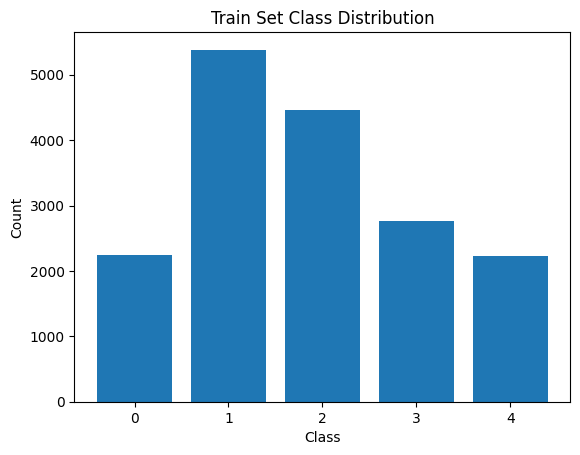

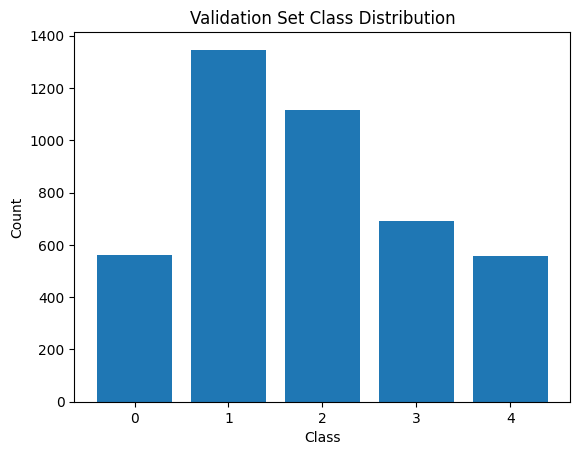

In [7]:
# Plot distribution of classes in train and val sets
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(unique)
    plt.show()
plot_class_distribution([labels[i] for i in train_idx], "Train Set Class Distribution")
plot_class_distribution([labels[i] for i in val_idx], "Validation Set Class Distribution")

In [8]:
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)

In [10]:
if DECAY_TYPE == "cosine":
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_STEPS
    )
else: # DECAY_TYPE == "linear"
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_STEPS
    )

In [11]:
training_params = {
    "name": "vit_training_notebook_run",
    "output_dir": "./output_notebook",
    "eval_every": 50,
    "num_steps": NUM_STEPS,
    "learning_rate": LEARNING_RATE, # Passa l'LR se il trainer lo calcola internamente
    "weight_decay": WEIGHT_DECAY,
    "decay_type": DECAY_TYPE,
    "warmup_steps": WARMUP_STEPS,
    "max_grad_norm": 1.0,
    "local_rank": -1, # Usa -1 per non distribuito in un singolo notebook
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "fp16": False, # Abilita o disabilita AMP
    "img_size": IMG_SIZE, # Necessario per UCB_Count_Score
    "train_batch_size": TRAIN_BATCH_SIZE, # Necessario per UCB_Count_Score
     "num_classes": NUM_CLASSES,
}

args = TrainingArguments(**training_params)

trainer = Trainer(
    args=args,
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer, 
    scheduler=scheduler 
)

Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


07/14/2025 14:11:46 - INFO - src.rl.train - Training arguments: TrainingArguments(
    name = vit_training_notebook_run,
    output_dir = ./output_notebook,
    eval_every = 50,
    learning_rate = 1e-05,
    weight_decay = 0.0,
    num_steps = 10000,
    decay_type = cosine,
    warmup_steps = 500,
    max_grad_norm = 1.0,
    local_rank = -1,
    seed = 42,
    gradient_accumulation_steps = 1,
    fp16 = False,
    num_classes = 6,
    img_size = 224,
    train_batch_size = 16,
    n_gpu = 1,
    device = cuda:0,
)
07/14/2025 14:11:46 - INFO - src.rl.train - Total parameters: 303.3M


In [ ]:
trainer.train()

07/14/2025 14:11:46 - INFO - src.rl.train - ***** Running training *****
07/14/2025 14:11:46 - INFO - src.rl.train -   Total optimization steps = 10000
07/14/2025 14:11:46 - INFO - src.rl.train -   Instantaneous batch size per GPU = 16
07/14/2025 14:11:46 - INFO - src.rl.train -   Total train batch size (w. parallel, distributed & accumulation) = 16
07/14/2025 14:11:46 - INFO - src.rl.train -   Gradient Accumulation steps = 1
Epoch 1 Training (1 / 10000 Steps) (loss=2.23422):   0%|| 0/1067 [00:02<?, ?it/s]/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:332: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 1 Training (50 / 10000 Steps) (loss=2.26183):   5%|| 49/1067 [00:33<10:39,  1.59it/s]07/14/2025 14:12:19 - INFO - src.rl.train - ***** Running Validation *****
07/14/2025 14:12:19 - INFO - src.rl.train -   Num steps = 267
07/14/2025 14:12:19 - INFO - src